# Reprogramming

The reprogramming dataset from *Biddy, B. A. et al. Nature 564, 219–224 (2018)*. This dataset has multiple time points for both clonal and state measurements. 

**Key components**: 
    
* Part I: Infer transition map using clones from all time points
    
* Part II: Infer transition map from end-point clones
    
* Part III: Infer transition map from state information alone
    
* Part IV: Predict early fate bias on day 3

In [1]:
import cospar as cs
import numpy as np

In [2]:
cs.logging.print_version()
cs.settings.verbosity=2
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # use png to reduce file size. 

cs.settings.data_path='CellTag_data' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='CellTag_figure' # A relative path to save figures. If not existed before, create a new one.

Running cospar 0.1.2 (python 3.6.12) on 2021-04-14 21:03.


## Loading data

In [3]:
adata_orig=cs.datasets.reprogramming()

In [4]:
adata_orig=cs.pp.initialize_adata_object(adata_orig)

Time points with clonal info: ['Day12' 'Day15' 'Day21' 'Day28' 'Day6' 'Day9']


In [5]:
cs.hf.update_time_ordering(adata_orig,updated_ordering=['Day6', 'Day9','Day12', 'Day15', 'Day21', 'Day28'])

The cells are barcoded over 3 rounds during the entire differentiation process. There are multiple ways to assemble the barcodes on day 0, day 3, and day 13 into a clonal ID. Below, we provide three variants: 
    
* Concatenate barcodes on day 0 and day 13, as in the original analysis (`adata_orig.obsm['X_clone_Concat_D0D3']`, the default); 

* Concatenate barcodes on day 0, day 3, and day 13 (`adata_orig.obsm['X_clone_Concat_D0D3D13']`);

* No concatenation; each cell has up to 3 barcodes (`adata_orig.obsm['X_clone_NonConcat_D0D3D13']`). 

The last choice keeps the nested clonal structure in the data. You choose any one of the clonal arrangement, e.g, `adata_orig.obsm['X_clone']=adata_orig.obsm['X_clone_Concat_D0D3']`. The three clonal arrangement gives very similar fate prediction.


In [6]:
adata_orig

AnnData object with n_obs × n_vars = 18803 × 28001
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca'

In [7]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['Reprogrammed', 'Others', 'Failed']
Available time points: ['Day6' 'Day9' 'Day12' 'Day15' 'Day21' 'Day28']
Clonal time points: ['Day6' 'Day9' 'Day12' 'Day15' 'Day21' 'Day28']


In [8]:
re_propressing=False
if re_propressing:
    cs.pp.get_highly_variable_genes(adata_orig)
    cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.03,confirm_change=True)
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40)
    cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3)
    #cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) # if this is changed, the cluster name used later will be wrong.
    cs.pl.embedding(adata_orig,color='time_info')

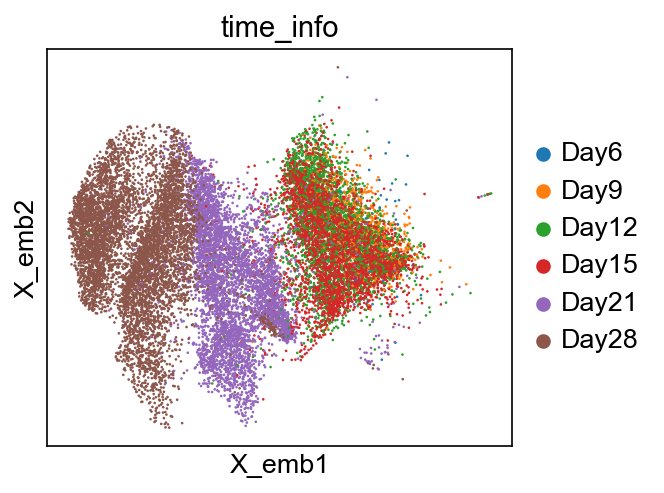

<Figure size 450x300 with 0 Axes>

In [9]:
cs.pl.embedding(adata_orig,color='time_info')

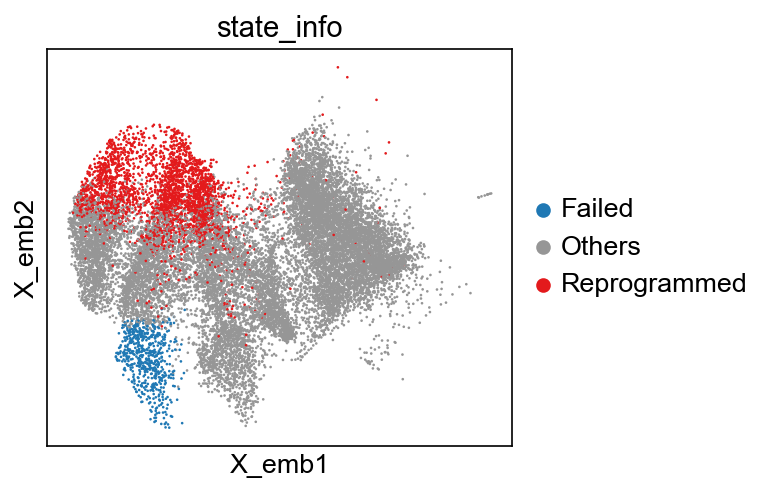

<Figure size 450x300 with 0 Axes>

In [10]:
cs.pl.embedding(adata_orig,color='state_info')

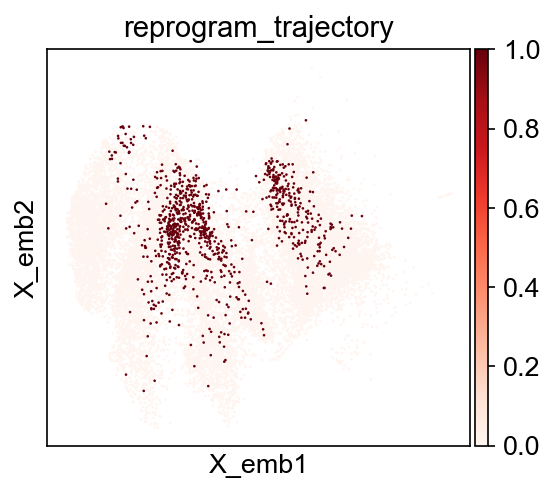

<Figure size 450x300 with 0 Axes>

In [11]:
cs.pl.embedding(adata_orig,color='reprogram_trajectory')

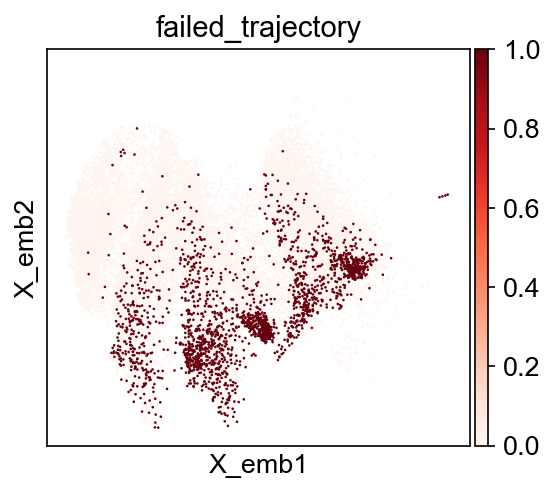

<Figure size 450x300 with 0 Axes>

In [12]:
cs.pl.embedding(adata_orig,color='failed_trajectory')

### Basic clonal analysis

Current clone id: 0
Current clone id: 50
Current clone id: 100
Current clone id: 150
Current clone id: 200
Current clone id: 250
Current clone id: 300
Current clone id: 350
Current clone id: 400
Current clone id: 450
Current clone id: 500
Current clone id: 550
Current clone id: 600
Current clone id: 650
Current clone id: 700
Current clone id: 750
Current clone id: 800
Current clone id: 850
Current clone id: 900
Current clone id: 950
Current clone id: 1000
Current clone id: 1050
Current clone id: 1100
Current clone id: 1150
Current clone id: 1200
Current clone id: 1250
Current clone id: 1300
Current clone id: 1350
Current clone id: 1400
Current clone id: 1450


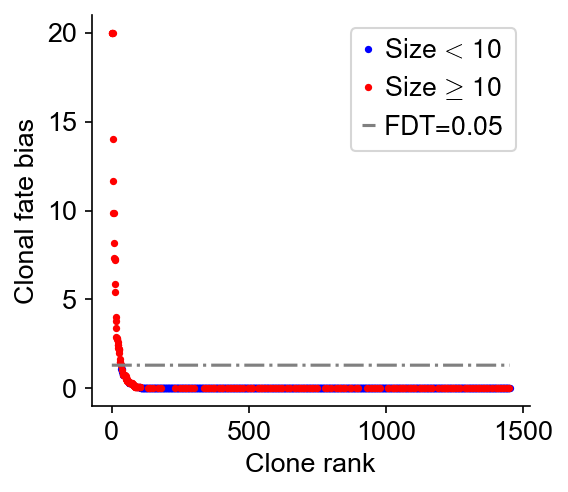

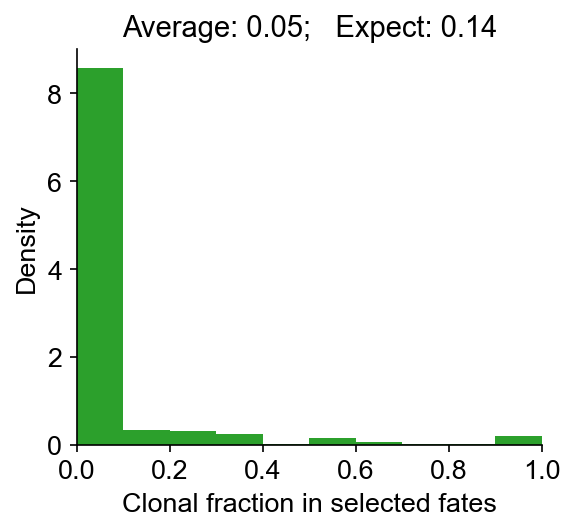

In [13]:
result=cs.pl.clonal_fate_bias(adata_orig,selected_fate='Reprogrammed',
            clone_size_thresh=10,compute_new=False,alternative='two-sided')

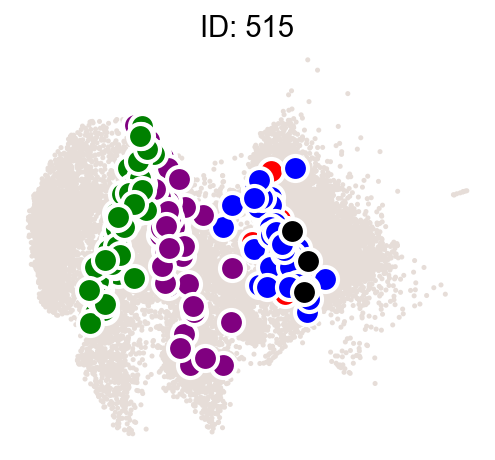

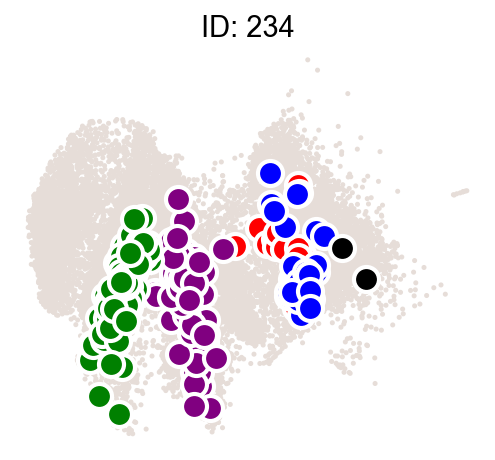

In [14]:
ids=result['Clone ID'][8:10]
#ids=[324,313,446,716,367]
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=ids) 

## Part I: Infer transition map using clones from all time points

### Map inference

Running it the first time takes ~20 mins, ~17 mins of which are used to compute the similarity matrix. When it is run again, it only takes ~3 mins.

In [15]:
sparsity_threshold=0.2 # 
#selected_clonal_time_points=['3','4','5','6','7','8']
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,clonal_time_points=['Day15','Day21'],
        later_time_point='Day28',smooth_array=[15,10,5],sparsity_threshold=0.2,
                intraclone_threshold=0.2)

Trying to set attribute `.uns` of view, copying.


------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: Day15--------
Step 1: Select time points
Number of multi-time clones post selection: 179
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.931
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.994
--------Current initial time point: Day21--------
Step 1: Select time points
Number of multi-time clones post selection: 226
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.919
Iteration 4,

In [16]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'intraclone_transition_map']

### Save or load pre-computed data

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata would print the `data_des`, which can be used to load the corresponding adata.

In [17]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    #file_path='CellTag_data/cospar_MultiTimeClone_Later_FullSpace0_t*Day15*Day21*Day28_adata_with_transition_map.h5ad'
    adata=cs.hf.read(file_path)


In [18]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['Reprogrammed', 'Others', 'Failed']
Available time points: ['Day6' 'Day9' 'Day12' 'Day15' 'Day21' 'Day28']
Clonal time points: ['Day6' 'Day9' 'Day12' 'Day15' 'Day21' 'Day28']


### Plotting

#### Single-cell transitions

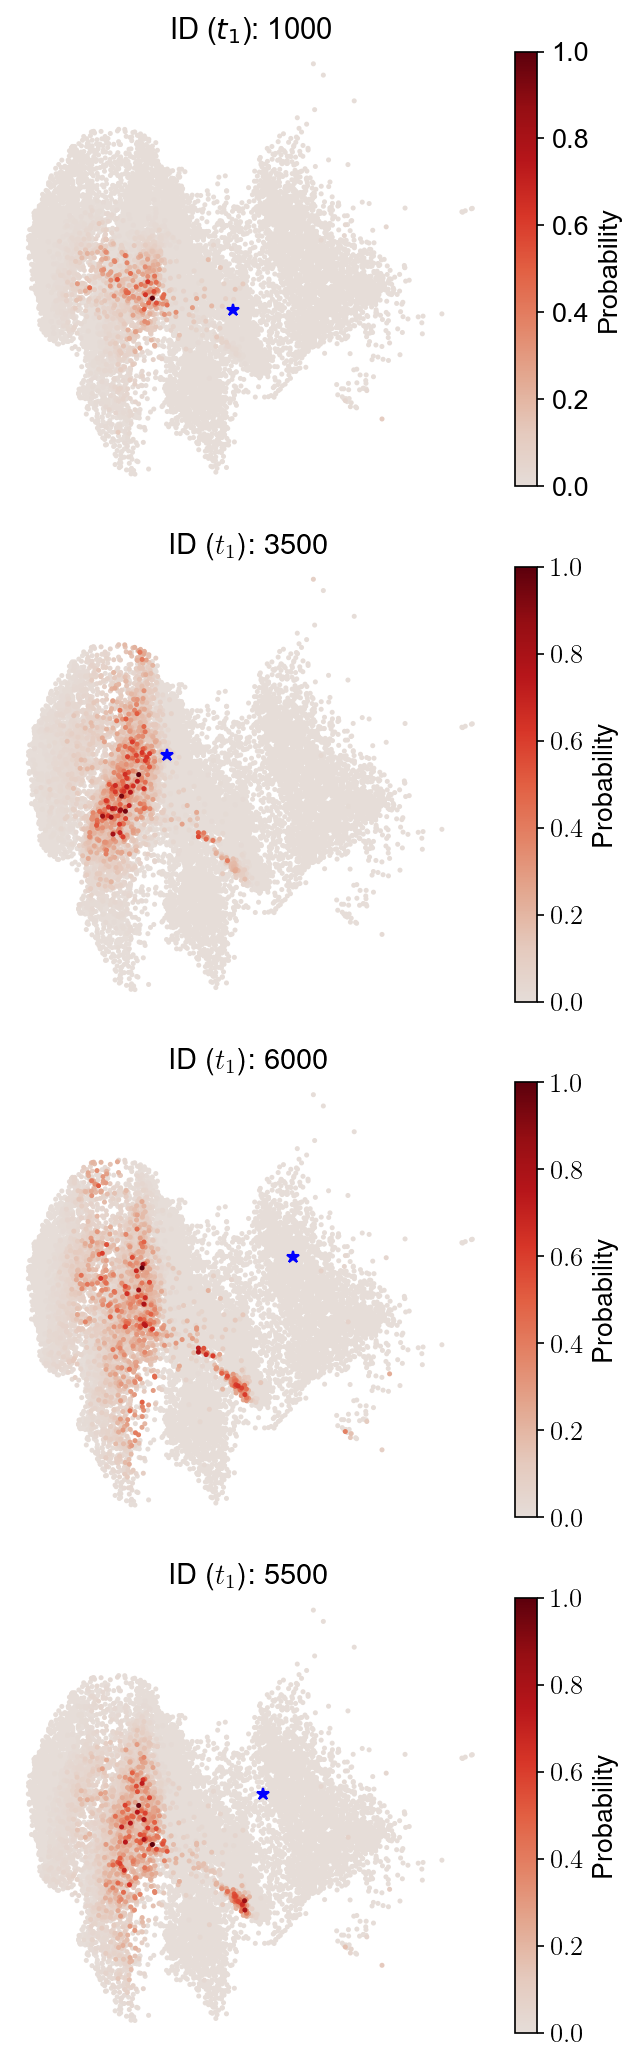

In [19]:
selected_state_id_list=[1000,3500,6000,5500]

cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_Tmap='transition_map',map_backward=False)

#### Fate map

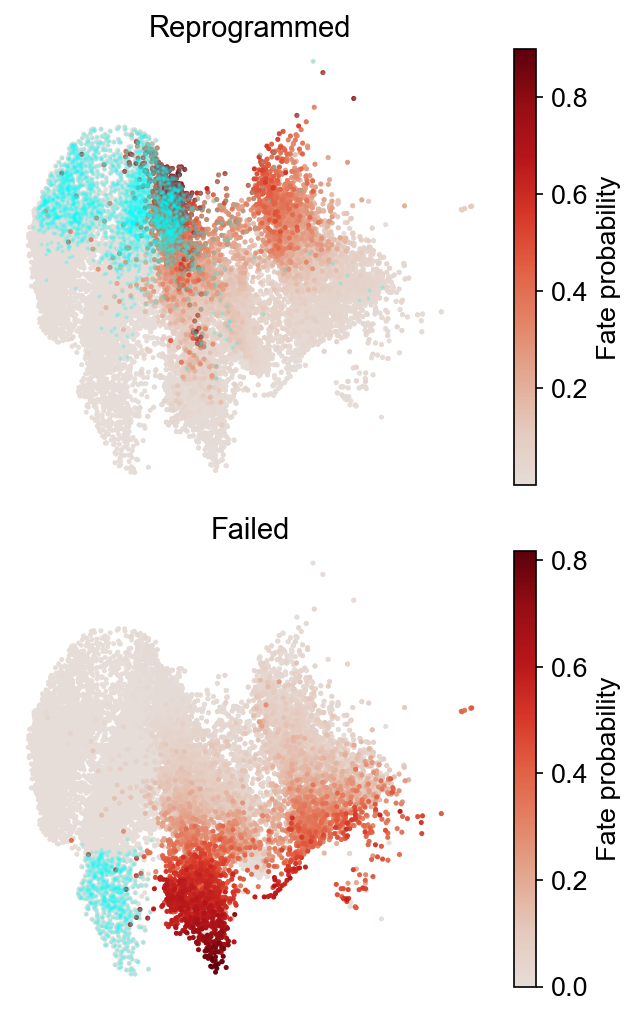

In [20]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_Tmap='transition_map',map_backward=True,plot_target_state=True,method='sum')

#### Fate bias

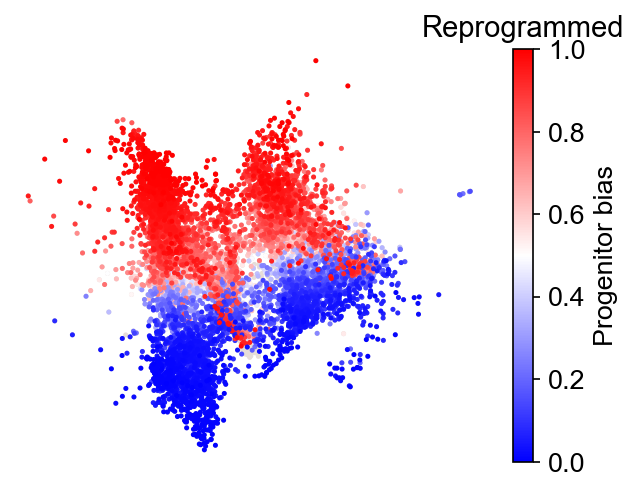

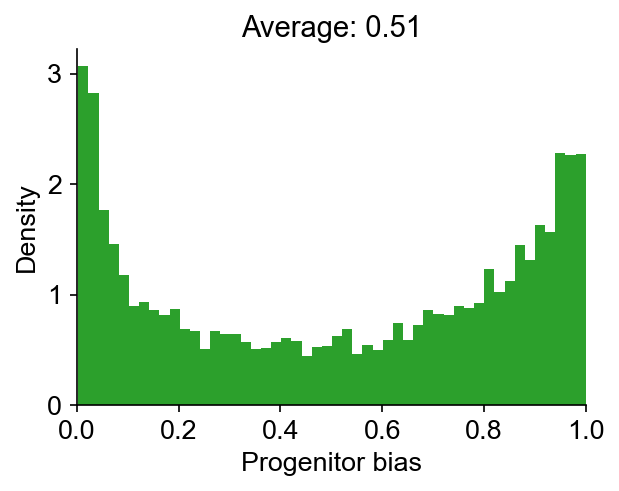

In [21]:
cs.pl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_Tmap='transition_map',
            plot_target_state=False,map_backward=True,method='norm-sum')

#### Identify differentially expressed genes

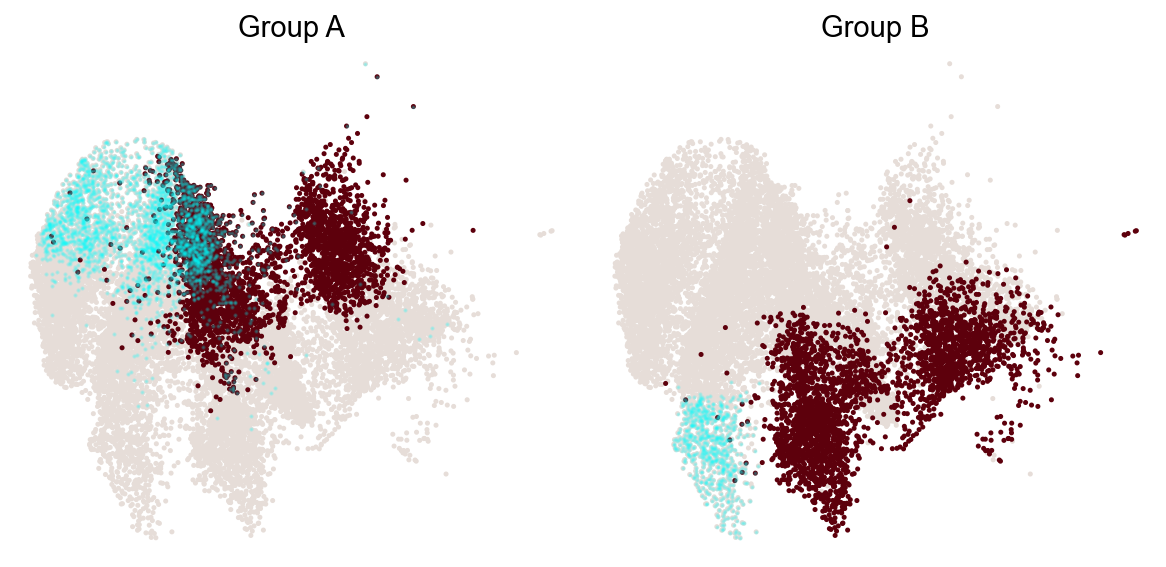

In [22]:
cs.pl.dynamic_trajectory_from_fate_bias(adata, selected_fates=['Reprogrammed','Failed'], 
 used_Tmap='transition_map', map_backward=True, selected_times=None,method='norm-sum',
    bias_threshold_A=0.5,bias_threshold_B=0.5, sum_fate_prob_thresh=0.2, avoid_target_states=False)


#### Differential genes for two ancestor groups

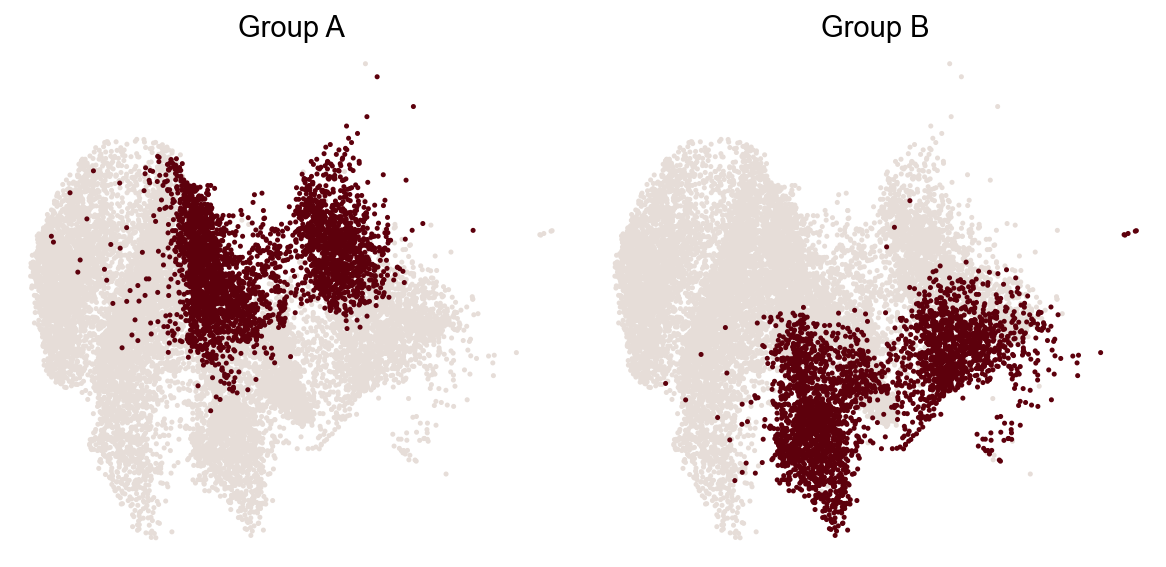

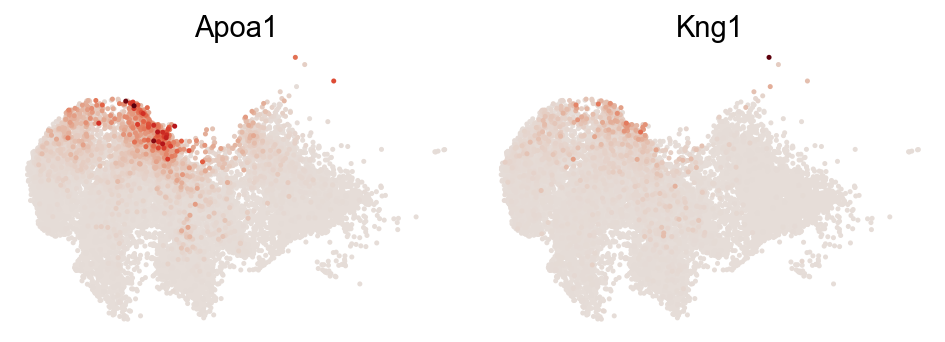

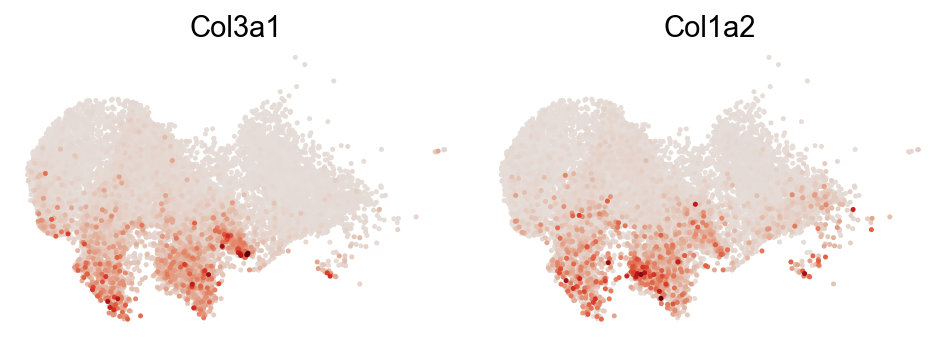

In [23]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=2)

In [24]:
# All, ranked, DGE genes for group A
dge_gene_A

index       gene         Qvalue    mean_1     mean_2     ratio
0        12      Apoa1   0.000000e+00  4.457667  85.585350 -3.987767
1       641       Kng1   1.224987e-28  0.592109   4.062109 -1.668799
2        28       Msln  3.024344e-247  0.866334   4.731968 -1.618824
3        19      Timp3  3.509424e-286  4.112589  14.616750 -1.610968
4        59       Ctgf  1.553989e-160  0.866784   4.424561 -1.538951
...     ...        ...            ...       ...        ...       ...
1418   5008     Prkaca   7.416176e-03  0.609062   0.609247 -0.000166
1419   5774      Noc4l   2.581401e-02  0.150920   0.151042 -0.000153
1420   5073  D10Jhu81e   8.336912e-03  0.335300   0.335399 -0.000107
1421   4529     Inppl1   2.982557e-03  0.367590   0.367622 -0.000033
1422   5462     Commd2   1.578160e-02  0.386672   0.386678 -0.000006

[1423 rows x 6 columns]

#### Gene trend along the trajectory

The results are based on pre-computed dynamic trajectories from the preceding step. It is
better to use the `intraclone_transition_map`. First, show the expression dynamics along the failed trajectory:

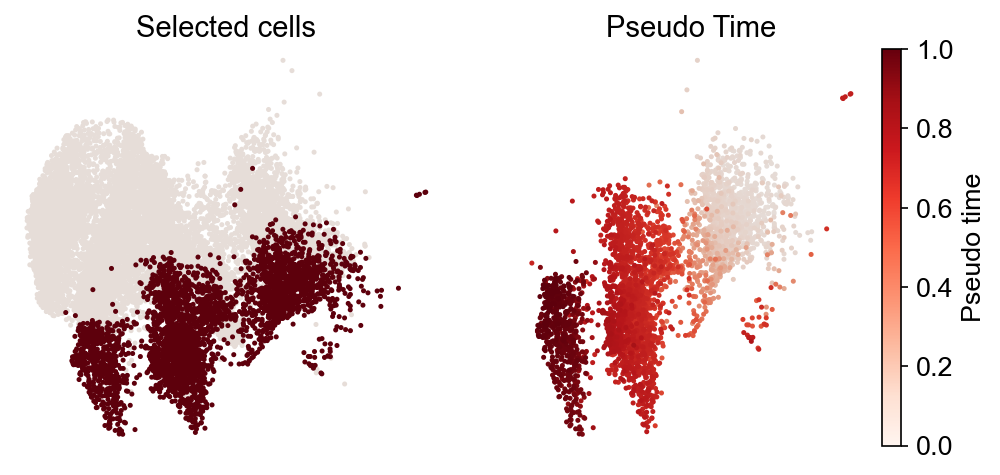

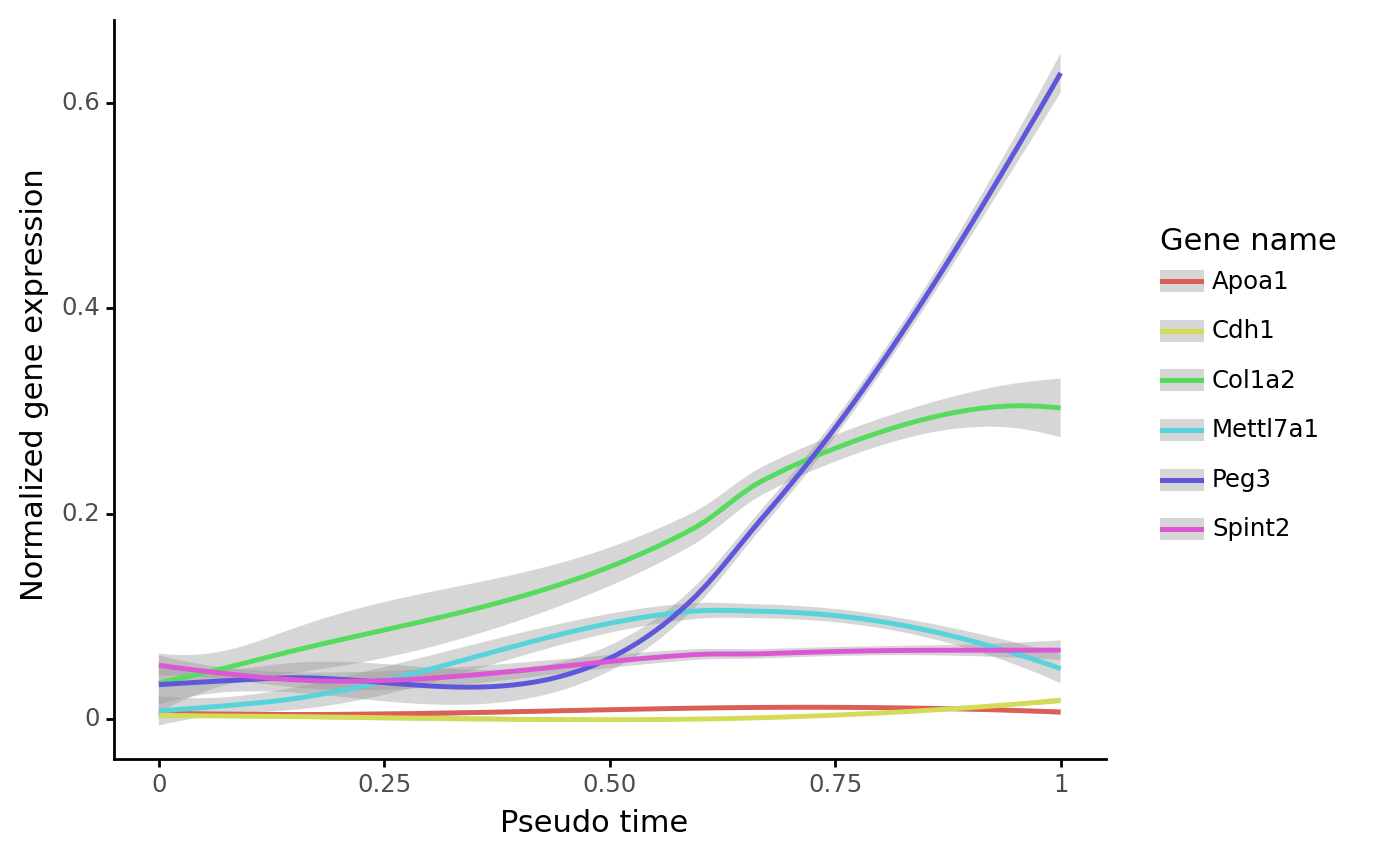

In [25]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Failed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backward=True, invert_PseudoTime=True)

Expression dynamics along the reprogramming trajectory:

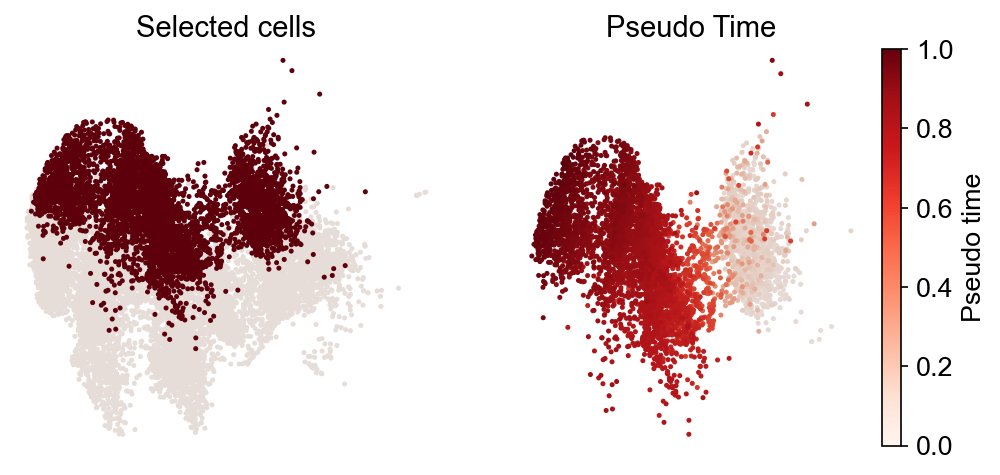

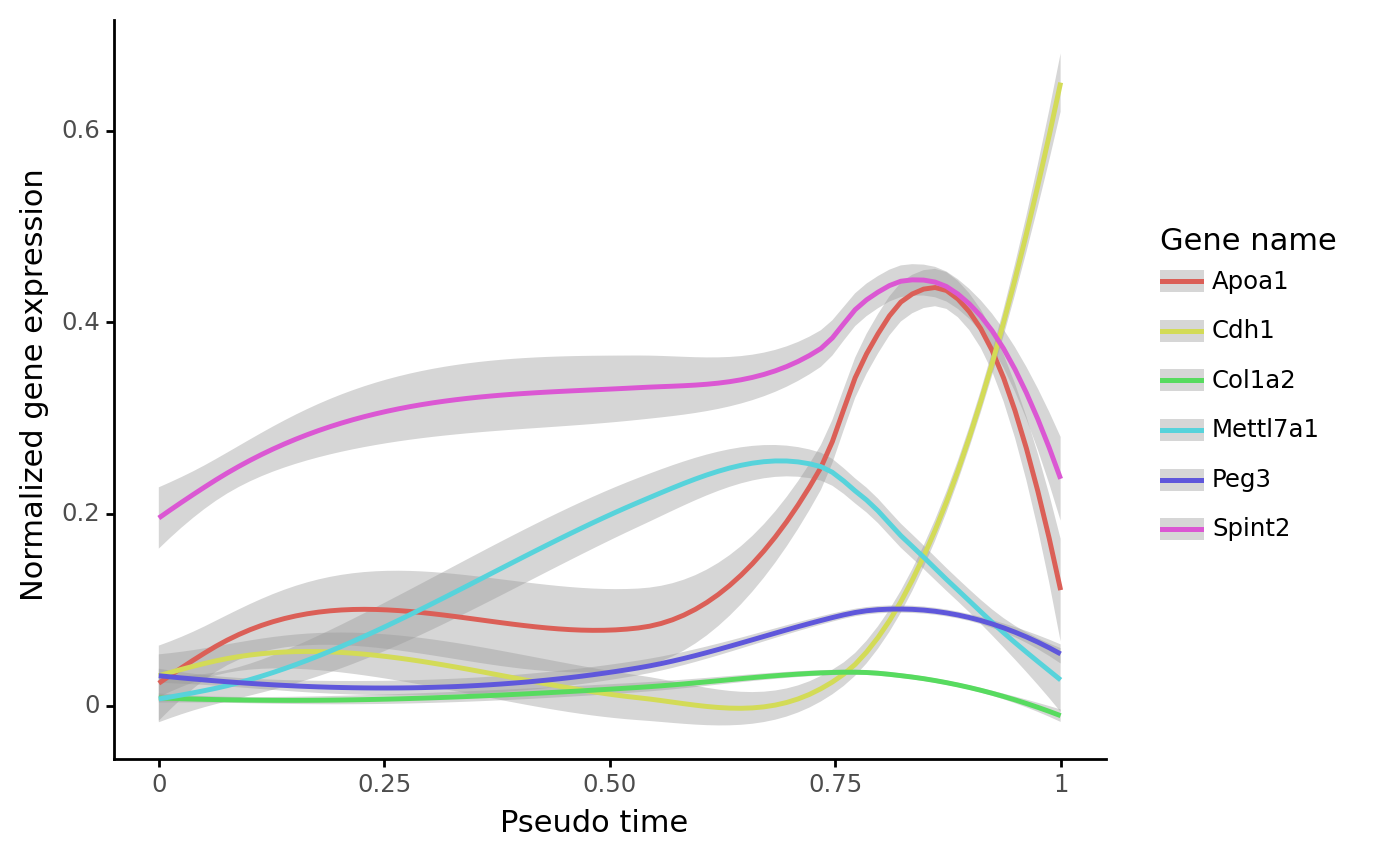

In [26]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
adata_selected=cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      map_backward=True, invert_PseudoTime=True)

## Part II: Infer transition map from end-point clones¶

It takes ~12 mins to compute for the first time (excluding the time for computing similarity matrix); and ~5 mins later.

In [27]:
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points=['Day15','Day21'],
        later_time_point='Day28',initialize_method='OT',OT_cost='SPD',
                        smooth_array=[15,10,5],sparsity_threshold=0.2)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: Day15--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.89
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.997
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.173
-----JointOpt Iteration 2: Infer initial clonal structure
-----JointOpt Iteration 2: Update the transition map by CoSpar
Load pre-computed similarity matrix
Ite

Trying to set attribute `.uns` of view, copying.


--------Current initial time point: Day21--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.853
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.985
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.25
-----JointOpt Iteration 2: Infer initial clonal structure
-----JointOpt Iteration 2: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_

In [28]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'OT_transition_map']

### Fate map

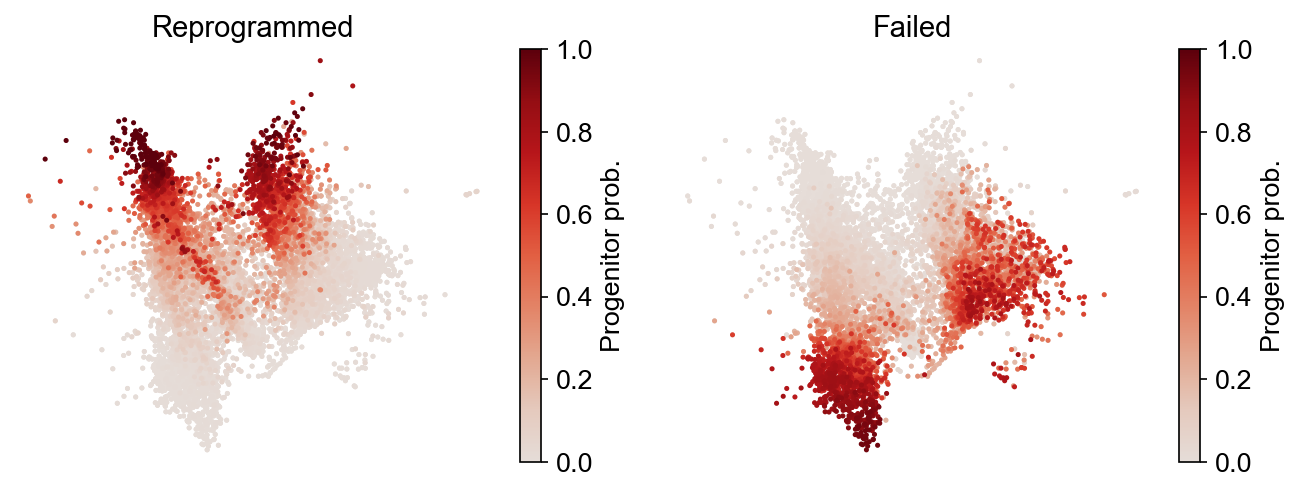

In [29]:
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],
               used_Tmap='transition_map',map_backward=True,plot_target_state=False,
               background=False,auto_color_scale=False,horizontal=True)

### Fate bias

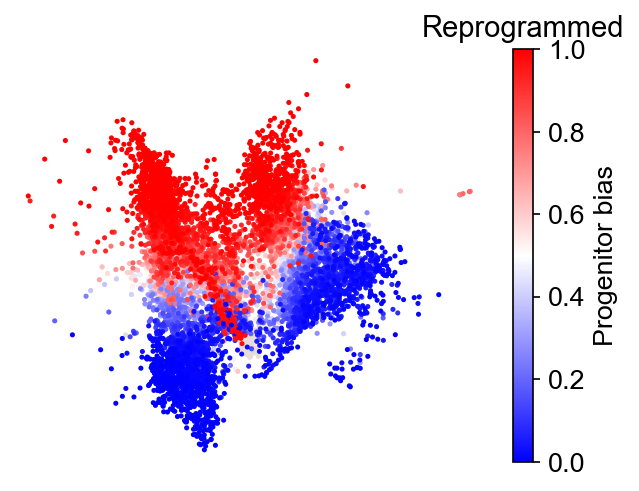

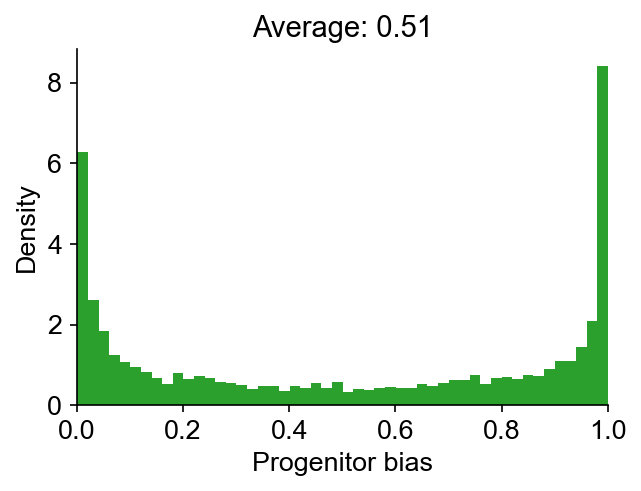

In [30]:
cs.pl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_Tmap='transition_map',
            plot_target_state=False,map_backward=True,method='norm-sum',
               sum_fate_prob_thresh=0.05)

## Part III: Infer transition map from state information alone

It takes ~5 mins

In [31]:
adata=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points=['Day15','Day21'],
        later_time_point='Day28',initialize_method='OT',OT_cost='SPD',
                smooth_array=[15,10,5],sparsity_threshold=0.2,use_full_Smatrix=True)

Step I: Generate pseudo clones where each cell has a unique barcode-----


Trying to set attribute `.uns` of view, copying.


Step II: Perform joint optimization-----


Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: Day15--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.882
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.987
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.347
-----JointOpt Iteration 2: Infer initial clonal structure
-----JointOpt Iteration 2: Update the transition map by CoSpar
Load pre-computed similarity matrix
It

Trying to set attribute `.uns` of view, copying.


--------Current initial time point: Day21--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.912
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.987
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.342
-----JointOpt Iteration 2: Infer initial clonal structure
-----JointOpt Iteration 2: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth

In [32]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'OT_transition_map']

### Fate bias

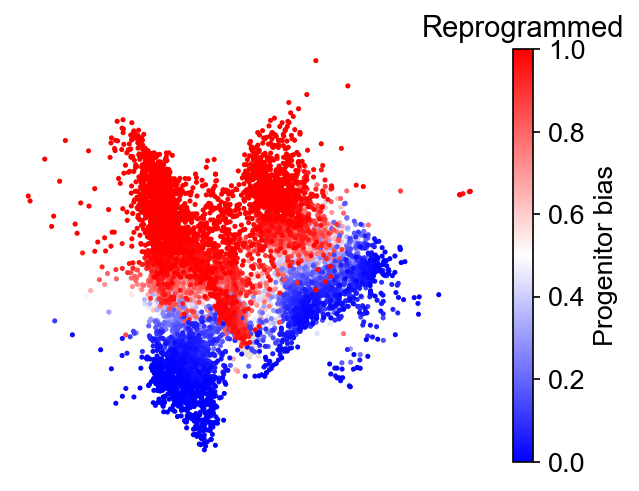

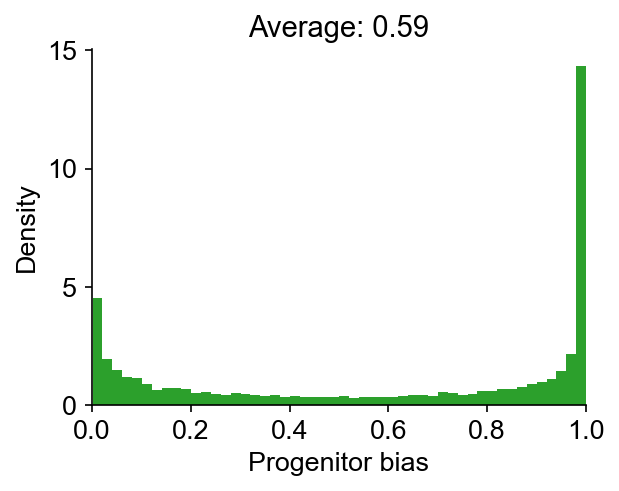

In [33]:
cs.pl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],used_Tmap='transition_map',
            selected_times=['Day15','Day21'],plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.05)

## Part IV: Predict early fate bias on day 3

### Load data

The above dataset only includes clonally-labeled states from day 6 to day 28. We load a dataset that has day-0 and day-3 states, which do not have clonal information. 


In [34]:
cs.settings.data_path='CellTag_data_full' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='CellTag_figure_full' # A relative path to save figures. If not existed before, create a new one.
adata_orig_1=cs.datasets.reprogramming_Day0_3_28()

In [35]:
adata_orig_1=cs.pp.initialize_adata_object(adata_orig_1)

Time points with clonal info: ['Day28']


In [36]:
cs.hf.update_time_ordering(adata_orig_1,updated_ordering=['Day0','Day3', 'Day28'])

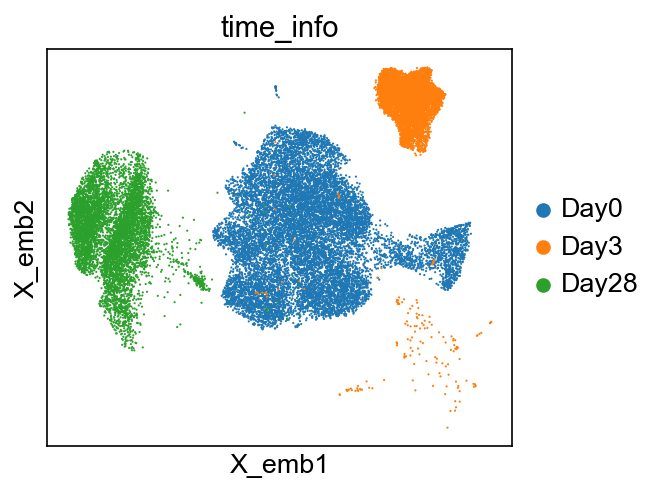

<Figure size 450x300 with 0 Axes>

In [37]:
cs.pl.embedding(adata_orig_1,color='time_info')

In [38]:
adata_orig_1

AnnData object with n_obs × n_vars = 27718 × 28001
    obs: 'predicted_doublet', 'row_counts', 'time_info', 'state_info', 'batch'
    var: 'highly_variable-0'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_emb', 'X_emb_old', 'X_emb_v1', 'X_pca'

### Infer transition map from end-point clones¶

In [39]:
adata_1=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig_1,initial_time_points=['Day3'],
    later_time_point=['Day28'],initialize_method='HighVar',smooth_array=[15,10,5], 
                        max_iter_N=[1,3],sparsity_threshold=0.2,use_full_Smatrix=True)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: Day3--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 1684 (t1); 1696 (t2). Common set: 960
Step b: convert the shared highly variable genes into clonal info------
Total used genes=888 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.858
Finishing initialization using HighVar, used time 177.46852493286133
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iterati

### Fate bias

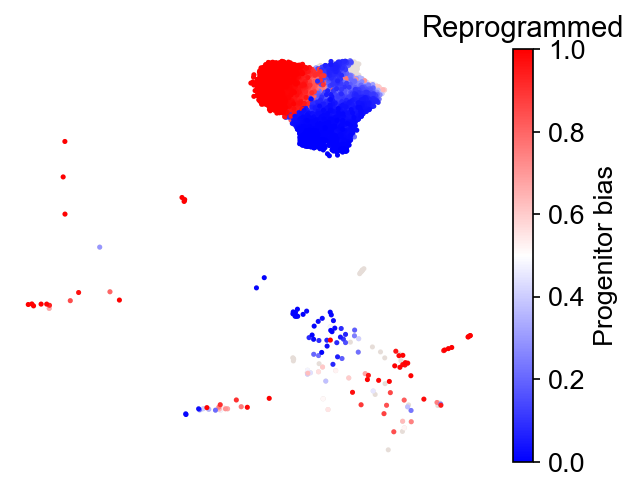

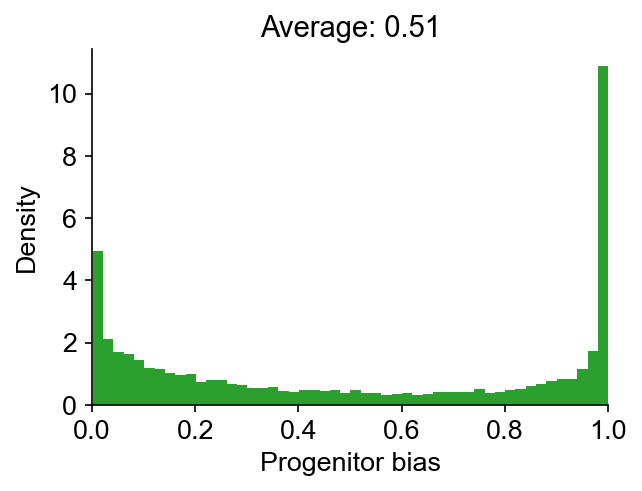

In [40]:
cs.pl.fate_bias(adata_1,selected_fates=['Reprogrammed','Failed'],used_Tmap='transition_map',
            selected_times=['Day3'],plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.1)

### Identify ancestor populations

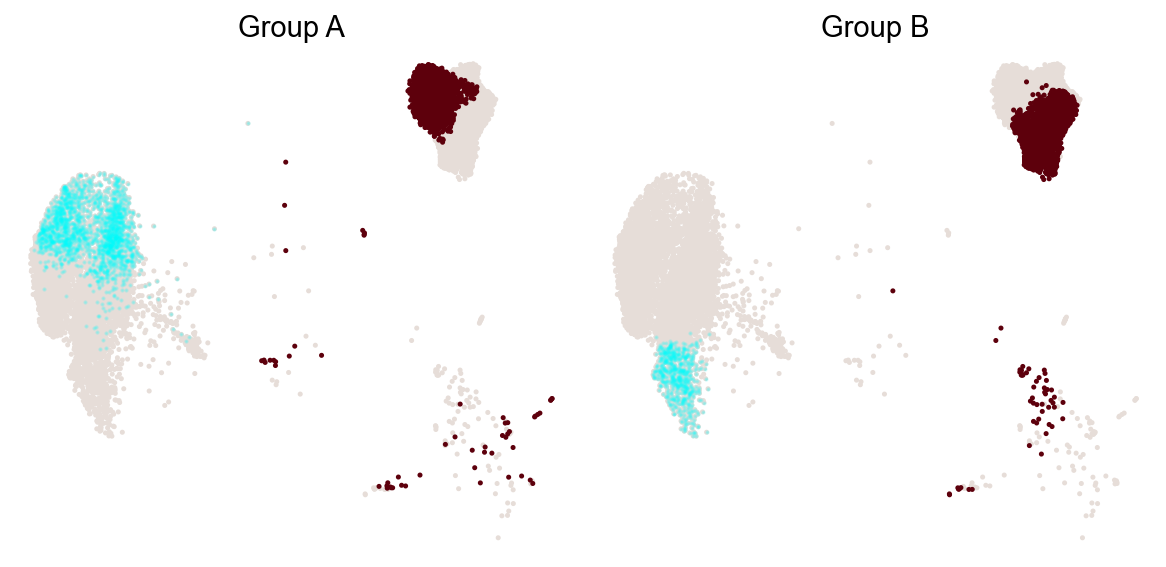

In [41]:
cs.pl.dynamic_trajectory_from_fate_bias(adata_1, selected_fates=['Reprogrammed','Failed'], 
 used_Tmap='transition_map', map_backward=True, selected_times=None,method='norm-sum',
    bias_threshold_A=0.5,bias_threshold_B=0.5, sum_fate_prob_thresh=0.2, avoid_target_states=False)


### DGE analysis

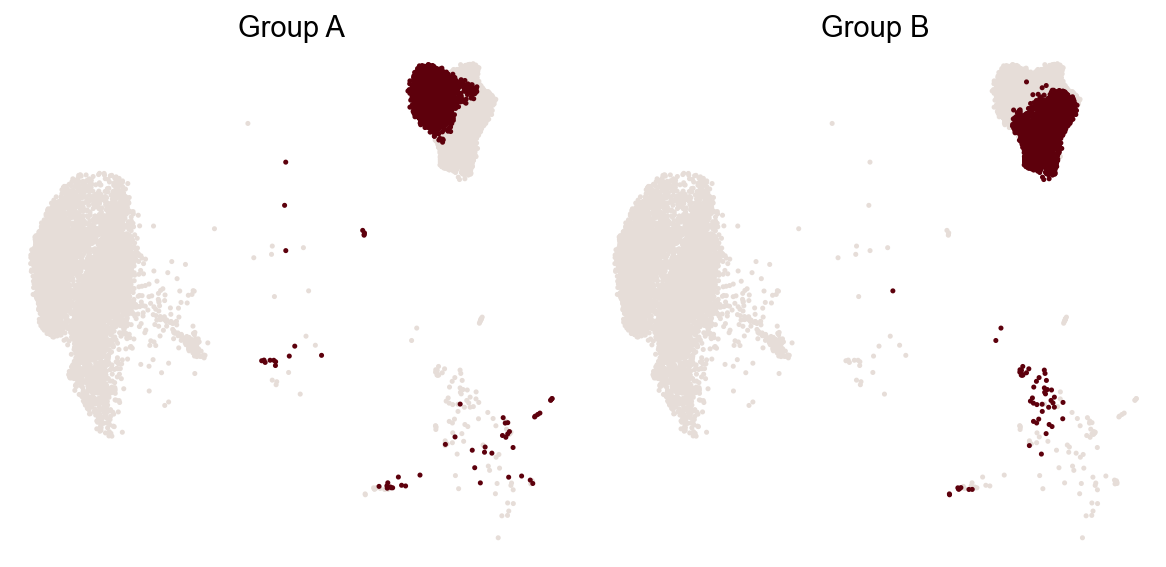

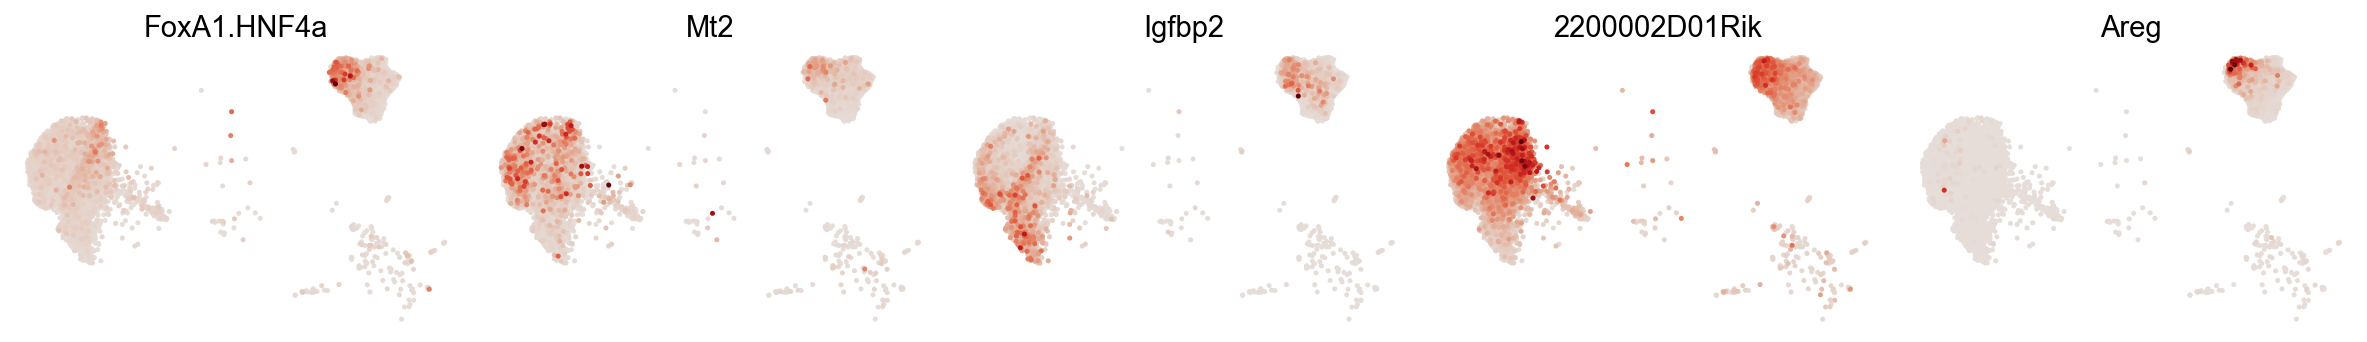

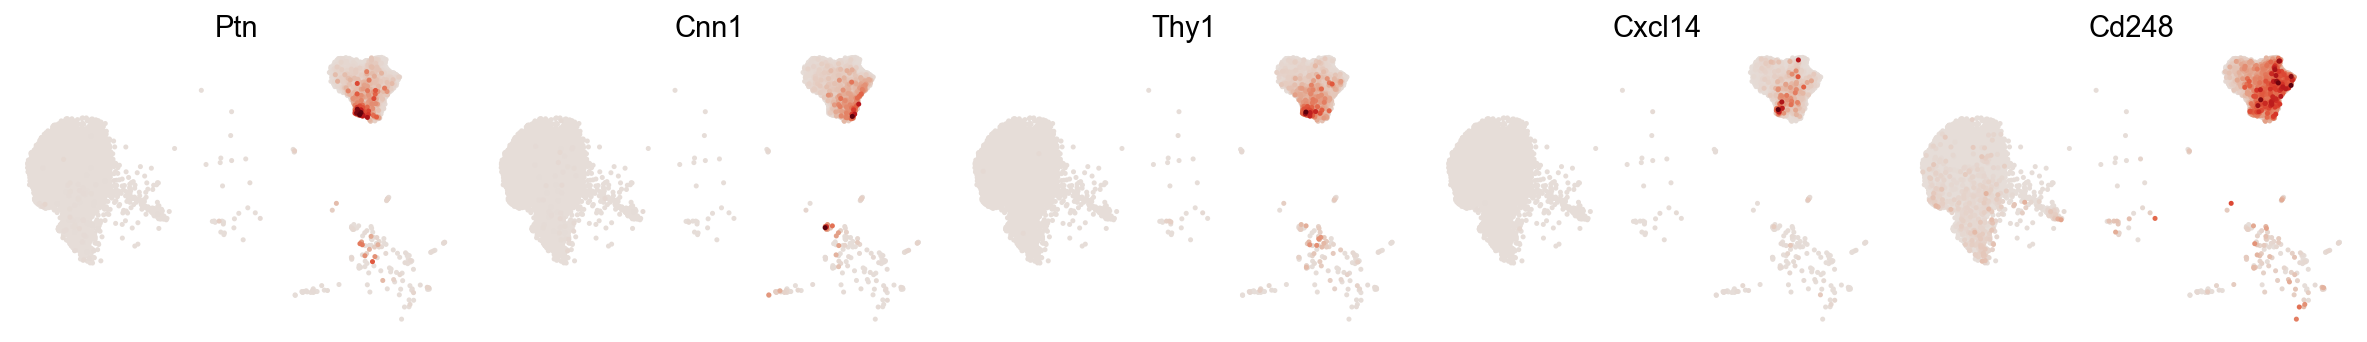

In [42]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata_1,plot_gene_N=5)

In [43]:
# All, ranked, DGE genes for group A
dge_gene_A

index           gene         Qvalue     mean_1     mean_2     ratio
0         3    FoxA1.HNF4a   0.000000e+00   1.929753   8.094416 -1.634202
1        14            Mt2  8.153069e-186   1.959146   5.824589 -1.205562
2       124         Igfbp2   1.775044e-66   1.198658   3.905924 -1.157902
3         4  2200002D01Rik   0.000000e+00   5.139995  12.629129 -1.150384
4        82           Areg   1.728882e-91   0.244969   1.620606 -1.073790
...     ...            ...            ...        ...        ...       ...
1950   2821        S100a11   7.592587e-03  13.126992  13.519002 -0.039488
1951   3261         Serbp1   2.417765e-02   4.964727   5.129974 -0.039425
1952   3500            Vcp   3.874242e-02   9.011789   9.261221 -0.035503
1953   3466          Uqcrq   3.542533e-02   6.474104   6.651648 -0.033870
1954   3444          Hspa8   3.376484e-02  14.233053  14.569138 -0.031484

[1955 rows x 6 columns]

Update cluster annotation on day 3

... storing 'state_info' as categorical


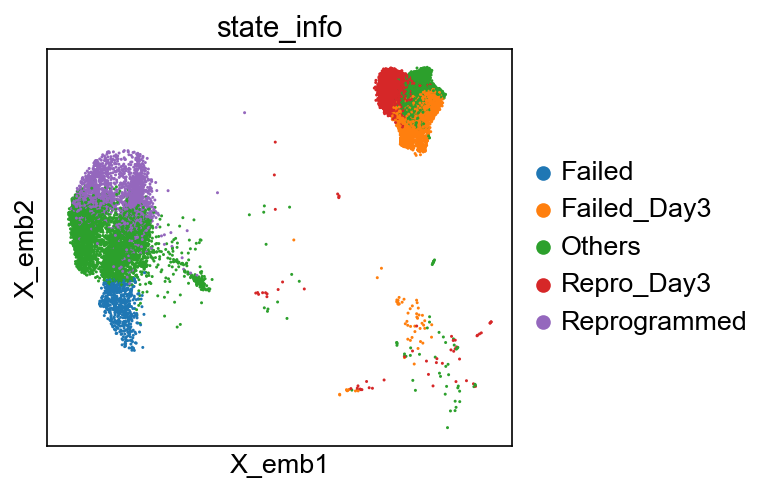

<Figure size 450x300 with 0 Axes>

In [44]:
cell_group_A=np.array(adata_1.obs['cell_group_A'])
cell_group_B=np.array(adata_1.obs['cell_group_B'])

x_emb=adata_1.obsm['X_emb'][:,0]
state_info=np.array(adata_1.obs['state_info']).astype('>U15')
sp_idx=cell_group_A & (x_emb>0)
state_info[sp_idx]='Repro_Day3'

sp_idx=cell_group_B & (x_emb>0)
state_info[sp_idx]='Failed_Day3'
adata_1.obs['state_info']=state_info
cs.pl.embedding(adata_1,color='state_info')

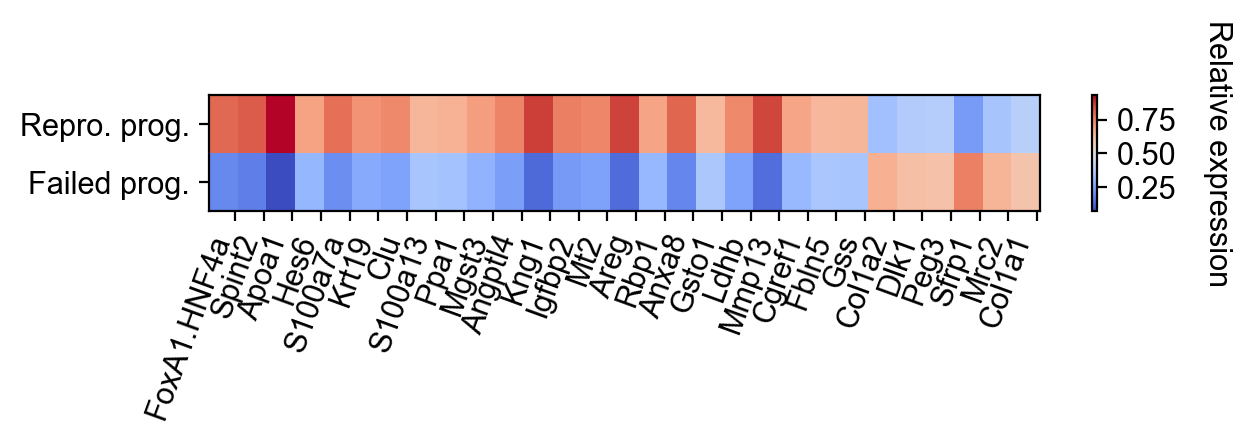

In [45]:
cs.settings.set_figure_params(fontsize=12)
gene_list=['FoxA1.HNF4a','Spint2','Apoa1', 'Hes6', 'S100a7a', 'Krt19',  'Clu',  'S100a13',
        'Ppa1', 'Mgst3',  'Angptl4','Kng1','Igfbp2','Mt2','Areg','Rbp1','Anxa8','Gsto1','Ldhb','Mmp13','Cgref1','Fbln5','Gss','Col1a2','Dlk1','Peg3','Sfrp1','Mrc2','Col1a1']

selected_fates=['Repro_Day3','Failed_Day3']
renames=['Repro. prog.','Failed prog.']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata_1,selected_genes=gene_list,
            selected_fates=selected_fates,rename_fates=renames,horizontal=True,fig_width=6.5,fig_height=2)

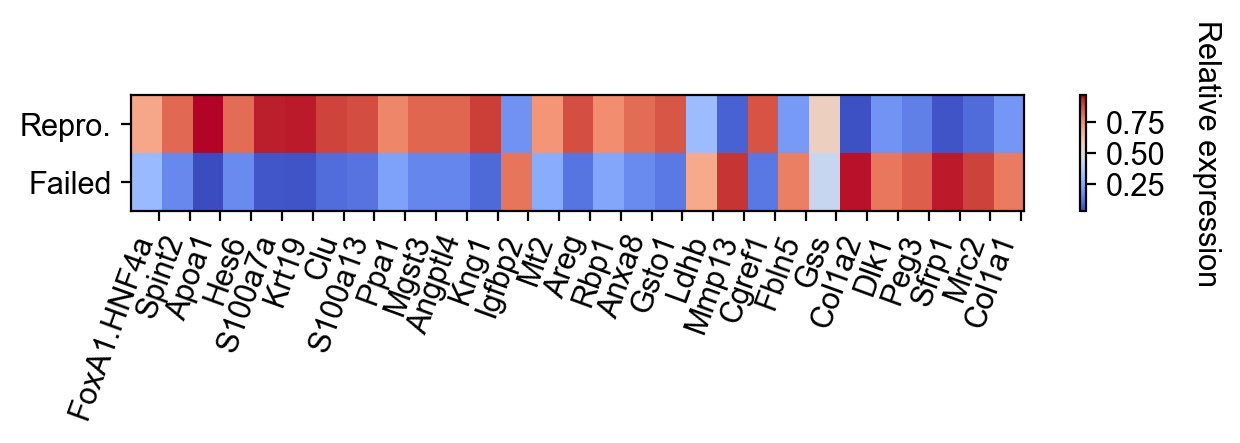

In [46]:
gene_list=['FoxA1.HNF4a','Spint2','Apoa1', 'Hes6', 'S100a7a', 'Krt19',  'Clu',  'S100a13',
        'Ppa1', 'Mgst3',  'Angptl4','Kng1','Igfbp2','Mt2','Areg','Rbp1','Anxa8','Gsto1','Ldhb','Mmp13','Cgref1','Fbln5','Gss','Col1a2','Dlk1','Peg3','Sfrp1','Mrc2','Col1a1']

selected_fates=['Reprogrammed','Failed']
renames=['Repro.','Failed']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata_1,selected_genes=gene_list,
            selected_fates=selected_fates,rename_fates=renames,horizontal=True,fig_width=6.5,fig_height=2)